<a href="https://colab.research.google.com/github/ericxu233/Anime-Face-Generator/blob/main/AnimeFaceGenerationDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else: 
  print(gpu_info)

Sun Nov 28 17:08:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from PIL import Image
import shutil
import tensorflow as tf
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Bool variable to determine which dataset we use
using_kaggle = True

In [5]:
#If using KAGGLE dataset
if using_kaggle:
  data_path = '/content/data'
  ! pip install kaggle
  ! mkdir ~/.kaggle
  ! cp /content/drive/MyDrive/APS360/Project/kaggle.json ~/.kaggle/kaggle.json
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d splcher/animefacedataset
  ! unzip ./animefacedataset.zip
  ! mkdir /content/data
  ! mv /content/images /content/data
#If using our own dataset REMEMBER TO UPLOAD TO RUNTIME ZIP FILE
else:
  #data_path = "/content/drive/MyDrive/APS360/Project/owndata"
  ! unzip /content/owndata.zip
  data_path = "/content/owndata"

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [6]:
#Defining globals
SIZE = 64
default_batch_size = 64
default_lr = 2e-4
default_generator_lr = 2e-4
default_discriminator_lr = 2e-4
default_generator_feature_map_size = 64
default_discriminator_feature_map_size = 64
default_noise_dimension = 100
default_num_of_channels = 3 #Because it is colored image
default_num_epochs = 30
default_beta1 = 0.5
default_beta2 = 0.999
num_of_gpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_of_gpu > 0) else "cpu")
htmls_path = "/content/htmls"
pdfs_path = "/content/pdfs"
generators_path = "/content/generators"
discriminators_path = "/content/discriminators"

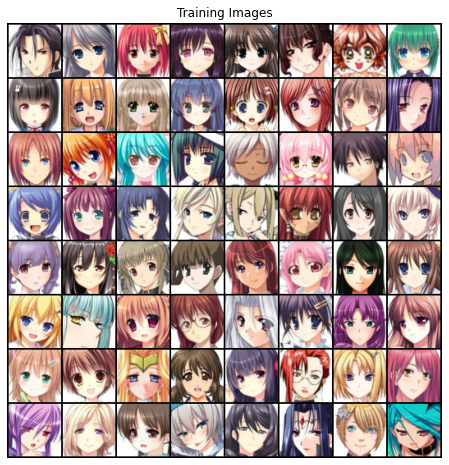

In [7]:
#Load dataset using torchvision.datasets.imagefolder from the data_path
dataset = dset.ImageFolder(data_path,
                           transform=transforms.Compose([
                               transforms.Resize(SIZE),
                               transforms.CenterCrop(SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


#Set the data_loader
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=default_batch_size)

# Plot some training images
training_images = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(training_images[0].cpu()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
#Use a class to define and store hyper-parameters
class HP():
  def __init__(self):
    self.batch_size = default_batch_size
    self.lr = default_lr
    self.beta1 = default_beta1
    self.beta2 = default_beta2
    self.num_epochs = default_num_epochs
    self.name = "bs:" + str(self.batch_size) + "_lr:" + str(self.lr) + "_b1:" + str(self.beta1) + "_b2:" + str(self.beta2) + "_ne:" + str(self.num_epochs)
  def __init__(self, batch_size=default_batch_size, lr=default_lr, beta1=default_beta1, beta2=default_beta2, num_epochs=default_num_epochs):
    self.batch_size = batch_size
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.num_epochs = num_epochs
    self.name = "bs:" + str(self.batch_size) + "_lr:" + str(self.lr) + "_b1:" + str(self.beta1) + "_b2:" + str(self.beta2) + "_ne:" + str(self.num_epochs)
  def setName(self):
    self.name = "bs:" + str(self.batch_size) + "_lr:" + str(self.lr) + "_b1:" + str(self.beta1) + "_b2:" + str(self.beta2) + "_ne:" + str(self.num_epochs)
default_HP = HP(default_batch_size, default_lr, default_beta1, default_beta2, default_num_epochs)

In [9]:
# Custom weights initialization called on Generator and Discriminator
# The weights must be initialized randomly from a Normal distribution with mean=0, stdev=0.02 according to DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
#64*64 Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.num_of_gpu = num_of_gpu
        self.name = "Generator"
        self.epochs_done = 0
        ngf = default_generator_feature_map_size
        self.gene = nn.Sequential(
            # Input the noise going towards a convolution map
            nn.ConvTranspose2d(default_noise_dimension, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, default_num_of_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (default_num_of_channels) x 64 x 64
        )

    def forward(self, x):
        return self.gene(x)

In [11]:
#128*128 Generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.num_of_gpu = num_of_gpu
        self.name = "Generator"
        self.epochs_done = 0
        ngf = default_generator_feature_map_size
        self.gene = nn.Sequential(
            # Input the noise going towards a convolution map
            nn.ConvTranspose2d(default_noise_dimension, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # (ngf*16)*4*4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8)*8*8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, default_num_of_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (default_num_of_channels) x 128 x 128
        )

    def forward(self, x):
        return self.gene(x)
"""

'\nclass Generator(nn.Module):\n    def __init__(self):\n        super(Generator, self).__init__()\n        self.num_of_gpu = num_of_gpu\n        self.name = "Generator"\n        self.epochs_done = 0\n        ngf = default_generator_feature_map_size\n        self.gene = nn.Sequential(\n            # Input the noise going towards a convolution map\n            nn.ConvTranspose2d(default_noise_dimension, ngf * 16, 4, 1, 0, bias=False),\n            nn.BatchNorm2d(ngf * 16),\n            nn.ReLU(True),\n            # (ngf*16)*4*4\n            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ngf * 8),\n            nn.ReLU(True),\n            # (ngf*8)*8*8\n            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ngf * 4),\n            nn.ReLU(True),\n            # state size. (ngf*4) x 16 x 16\n            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ngf * 2),\n       

In [12]:
# Create the generator
def create_generator():
  generator = Generator().to(device)

  # Handle multi-gpu if desired
  if (device.type == 'cuda') and (num_of_gpu > 1):
      generator = nn.DataParallel(generator, list(range(num_of_gpu)))

  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.02.
  generator.apply(weights_init)

  return generator

In [13]:
#64*64 Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ngpu = num_of_gpu
        self.name = "Discriminator"
        self.epochs_done = 0
        ndf = default_discriminator_feature_map_size
        self.disc = nn.Sequential(
            # input is (ndf) x 64 x 64
            nn.Conv2d(default_num_of_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.disc(x)

In [14]:
#128*128 Discriminator
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ngpu = num_of_gpu
        self.name = "Discriminator"
        self.epochs_done = 0
        ndf = default_discriminator_feature_map_size
        self.disc = nn.Sequential(
            # input is (ndf) x 128 x 128
            nn.Conv2d(default_num_of_channels, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            #(ndf*16)*4*4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.disc(x)
"""

'\nclass Discriminator(nn.Module):\n    def __init__(self):\n        super(Discriminator, self).__init__()\n        self.ngpu = num_of_gpu\n        self.name = "Discriminator"\n        self.epochs_done = 0\n        ndf = default_discriminator_feature_map_size\n        self.disc = nn.Sequential(\n            # input is (ndf) x 128 x 128\n            nn.Conv2d(default_num_of_channels, ndf, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ndf),\n            nn.LeakyReLU(0.2, inplace=True),\n            # state size. (ndf) x 64 x 64\n            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ndf * 2),\n            nn.LeakyReLU(0.2, inplace=True),\n            # state size. (ndf*2) x 32 x 32\n            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),\n            nn.BatchNorm2d(ndf * 4),\n            nn.LeakyReLU(0.2, inplace=True),\n            # state size. (ndf*4) x 16 x 16\n            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),\n            nn.Batch

In [15]:
# Create the Discriminator
def create_discriminator():
  discriminator = Discriminator().to(device)

  # Handle multi-gpu if desired
  if (device.type == 'cuda') and (num_of_gpu > 1):
      discriminator = nn.DataParallel(discriminator, list(range(num_of_gpu)))

  # Apply the weights_init function to randomly initialize all weights
  #  to mean=0, stdev=0.2.
  discriminator.apply(weights_init)

  return discriminator

In [16]:
def download_model_state(path):
  files.download(path)

In [31]:
def train(generator, discriminator, hp=default_HP, first_time=True, additional_epochs=0):

  #Set up the hyperparameters by using the general class HP
  batch_size = hp.batch_size
  lr = hp.lr
  beta1 = hp.beta1
  beta2 = hp.beta2
  num_epochs = hp.num_epochs

  # These arrays will show how our model progresses
  img_list = []
  generator_losses = []
  discriminator_losses = []
  iters = 0

  # Use BCEWithLogitsLoss function in order to prevent exploding/diminishing gradient
  criterion = nn.BCEWithLogitsLoss()

  # Create batch of latent vectors that we will use to visualize
  #  the progression of the generator
  fixed_noise = torch.randn(64, default_noise_dimension, 1, 1, device=device)

  # Uses 1 and 0 for real and fake images
  real_label = 1.
  fake_label = 0.

  # Using Adam optimizer because it is faster
  optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
  optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

  generator = generator.to(device)
  discriminator = discriminator.to(device)

  print("Training Starts")
  epoch = 0
  if not first_time:
    epoch = num_epochs-additional_epochs
    generator.epochs_done = epoch
    discriminator.epochs_done = epoch
  while epoch < num_epochs:
      for i, data in enumerate(dataloader, 0):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          ## Train with all-real batch

          # Clean up the gradient first 
          discriminator.zero_grad()
          # Format batch
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          #Fill the label with 
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          # Forward pass real batch through D
          output = discriminator(real_cpu).view(-1)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward()
          D_x = output.mean().item()

          ## Train with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(b_size, default_noise_dimension, 1, 1, device=device)
          # Generate fake image batch with G
          fake = generator(noise)
          label.fill_(fake_label)
          # Classify all fake batch with D
          output = discriminator(fake.detach().to(device)).view(-1)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch, accumulated (summed) with previous gradients
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Compute error of D as sum over the fake and the real batches
          errD = errD_real + errD_fake
          # Update D
          optimizerD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          generator.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = discriminator(fake).view(-1)
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()

          # Output training stats
          if i % 100 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                      errD.item(), errG.item()))

          # Save Losses for plotting later
          generator_losses.append(errG.item())
          discriminator_losses.append(errD.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              with torch.no_grad():
                  fake = generator(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

          iters += 1
      generator.epochs_done += 1
      discriminator.epochs_done += 1
      epoch += 1
  if not os.path.isdir(generators_path):
    ! mkdir /content/generators
  if not os.path.isdir(discriminators_path):
    ! mkdir /content/discriminators
  g_path = "{0}/{1}_bs_{2}_lr_{3}_b1_{4}_b2_{5}_epoch_{6}".format(generators_path, generator.name, batch_size, lr, beta1, beta2, generator.epochs_done)
  torch.save(generator.state_dict(), g_path)
  d_path = "{0}/{1}_bs_{2}_lr_{3}_b1_{4}_b2_{5}_epoch_{6}".format(discriminators_path, discriminator.name, batch_size, lr, beta1, beta2, discriminator.epochs_done)
  torch.save(discriminator.state_dict(), d_path)
  download_model_state(g_path)
  #download_model_state(d_path)
  return generator_losses, discriminator_losses, img_list

In [18]:
def plot_training_curves(generator_losses, discriminator_losses, hp=default_HP):
  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(generator_losses,label="G")
  plt.plot(discriminator_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  pdf_name = hp.name + ".pdf"
  plt.savefig(pdf_name)
  files.download(pdf_name)
  if not os.path.isdir(pdfs_path):
    ! mkdir /content/pdfs
  shutil.move(pdf_name, pdfs_path)
  plt.show()

In [19]:
def save_progression(img_list, hp):
  #%%capture
  fig = plt.figure(figsize=(8,8))
  plt.axis("off")
  ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
  ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

  html = HTML(ani.to_jshtml())
  data = html.data
  html_string = "afg_" + hp.name + ".html"
  with open(html_string, 'w') as f:
    f.write(data)
  #Download to local laptop
  files.download(html_string)
  #Move html to runtime directory
  if not os.path.isdir(htmls_path):
    ! mkdir /content/htmls
  shutil.move(html_string, htmls_path)
  display(html)

In [20]:
def compare_real_fake(img_list):
  # Grab a batch of real images from the dataloader
  real_batch = next(iter(dataloader))

  # Plot the real images
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

  # Plot the fake images from the last epoch
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[-1],(1,2,0)))
  plt.show()

In [21]:
def train_plot_save_show(generator, discriminator, hp=default_HP, first_time=True, additional_epochs=0):
  generator_losses, discriminator_losses, img_list = train(generator, discriminator, hp, first_time, additional_epochs)
  plot_training_curves(generator_losses, discriminator_losses, hp)
  save_progression(img_list, hp)
  compare_real_fake(img_list)
  return generator, discriminator, generator_losses, discriminator_losses, img_list

In [22]:
def generate_show_fake(generator):
  random_noise = torch.randn(64, default_noise_dimension, 1, 1, device=device)
  fake = generator(random_noise.cpu()).detach().cpu()
  plt.imshow(np.transpose(fake[-1],(1,2,0)))
  plt.show()

In [32]:
def load_generator(hp):
  path = "/content/generators/Generator_bs_{0}_lr_{1}_b1_{2}_b2_{3}_epoch_{4}".format(hp.batch_size, hp.lr, hp.beta1, hp.beta2, hp.num_epochs)
  state = torch.load(path)
  generator = Generator()
  generator.load_state_dict(state)
  return generator

In [33]:
def load_discriminator(hp):
  path = "/content/discriminators/Discriminator_bs_{0}_lr_{1}_b1_{2}_b2_{3}_epoch_{4}".format(hp.batch_size, hp.lr, hp.beta1, hp.beta2, hp.num_epochs)
  state = torch.load(path)
  discriminator = Discriminator()
  discriminator.load_state_dict(state)
  return discriminator

In [25]:
def train_download_HP(hp=default_HP):
  generator = create_generator()
  discriminator = create_discriminator()
  generator, discriminator, generator_losses, discriminator_losses, img_list = train_plot_save_show(generator, discriminator, hp)

In [26]:
def train_download_many_HP(hps):
  for hp in tqdm(hps):
    train_download_manyHP(hp)
  ! zip -r htmls.zip /content/htmls
  ! zip -r generators.zip /content/generators
  files.download("/content/htmls.zip") 
  files.download("/content/generators.zip") 

In [27]:
def continue_training(hp=default_HP, additional_epochs=5):
  generator = load_generator(hp)
  discriminator = load_discriminator(hp)
  hp.num_epochs += additional_epochs
  hp.setName()
  train_plot_save_show(generator, discriminator, hp, first_time=False, additional_epochs=additional_epochs)


In [ ]:
continue_training(HP(num_epochs=80), additional_epochs=10)

Training Starts
[80/90][0/994]	Loss_D: 0.0145	Loss_G: 8.8277
[80/90][100/994]	Loss_D: 0.0319	Loss_G: 9.1380
[80/90][200/994]	Loss_D: 0.0120	Loss_G: 7.1851
[80/90][300/994]	Loss_D: 0.0839	Loss_G: 5.1865
[80/90][400/994]	Loss_D: 0.0208	Loss_G: 6.5035
[80/90][500/994]	Loss_D: 0.1735	Loss_G: 4.6654
[80/90][600/994]	Loss_D: 0.0313	Loss_G: 6.5211
[80/90][700/994]	Loss_D: 0.0198	Loss_G: 6.8592
[80/90][800/994]	Loss_D: 0.0254	Loss_G: 6.0593
[80/90][900/994]	Loss_D: 0.0148	Loss_G: 7.4328
[81/90][0/994]	Loss_D: 0.0215	Loss_G: 6.5793
[81/90][100/994]	Loss_D: 0.0108	Loss_G: 7.5030
[81/90][200/994]	Loss_D: 0.0052	Loss_G: 8.2568
[81/90][300/994]	Loss_D: 0.1516	Loss_G: 4.6850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


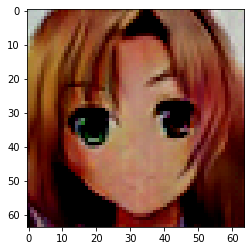

In [64]:
generator = load_generator(HP(num_epochs=80))
generate_show_fake(generator)